# Critical initialisation for noisy ReLU networks.

In this notebook, we provide code to reproduce Figure 3 in the paper. 

In [1]:
# imports
import os, sys, pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap

# custom import
from src.numpy_simulation import *
# from src.simulation import *
from src.viz import get_colours
from src.utils import load_experiment
from src.theory import depth
from src.theory import critical_point

# plot settings
import matplotlib as mpl
# mpl.rcParams['figure.figsize'] = [14.0, 6.0]
mpl.rcParams['font.size'] = 100

sns.set_context("paper", font_scale=2)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
plt.rcParams['image.cmap'] = 'viridis'
# plt.rcParams.update({'font.size': 50})

# results directory
relative_results_dir = "results"
results_dir = os.path.join(relative_results_dir)

## --- Noisy variance map for ReLU with multiplicative noise ---

In [ ]:
experiments = [
    {"dist": "bern", "noise": ('prob_1', 0.6), "act":"relu", "init":"underflow"}, 
    {"dist": "bern", "noise": ('prob_1', 0.6), "act":"relu", "init":"overflow"}, 
    {"dist": "bern", "noise": ('prob_1', 0.6), "act":"relu", "init":"crit"},
    {"dist": "mult gauss", "noise": ('std', 0.25), "act":"relu", "init":"underflow"},
    {"dist": "mult gauss", "noise": ('std', 0.25), "act":"relu", "init":"overflow"}, 
    {"dist": "mult gauss", "noise": ('std', 0.25), "act":"relu", "init":"crit"}
]

for i, experiment in enumerate(experiments):
    dist = experiment['dist']
    noise = experiment['noise']
    act = experiment['act']
    init = experiment['init']
    
    # run simulations for scenario
    noisy_signal_prop_simulations(dist, noise, act, init, seed=i)

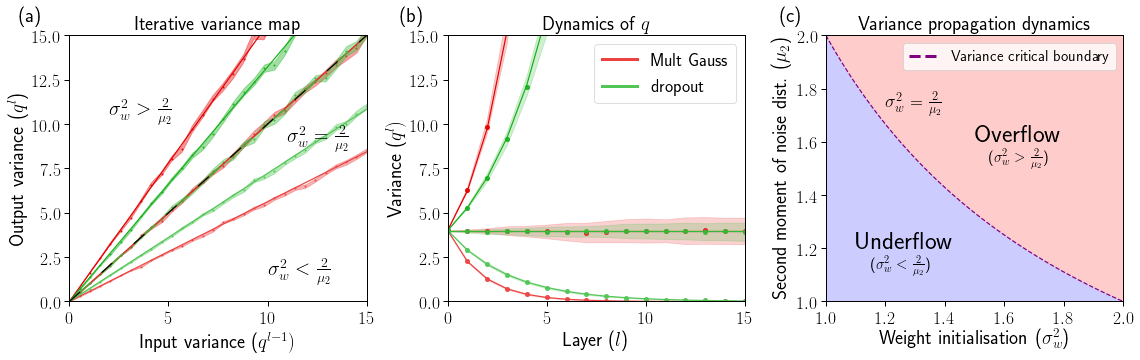

In [5]:
# Dictionary for data that needs to be extracted
tests = [
    {
        "distributions": [{"dist": "mult gauss", "std": 0.25}],
        "activations": ["relu"],
        "inits": ["underflow"]
    },
    {
        "distributions": [{"dist": "mult gauss", "std": 0.25}],
        "activations": ["relu"],
        "inits": ["overflow"]
    },
    {
        "distributions": [{"dist": "mult gauss", "std": 0.25}],
        "activations": ["relu"],
        "inits": ["crit"]
    }
    ,
    {
        "distributions": [{"dist": "bern", "prob_1": 0.6}],
        "activations": ["relu"],
        "inits": ["underflow"]
    },
    {
        "distributions": [{"dist": "bern", "prob_1": 0.6}],
        "activations": ["relu"],
        "inits": ["overflow"]
    },
    {
        "distributions": [{"dist": "bern", "prob_1": 0.6}],
        "activations": ["relu"],
        "inits": ["crit"]
    }
]

############################################################################
# q - length / variance plots
############################################################################
nq = 30
qmax = 15
qrange = np.linspace(0, qmax, nq)
widxs = [0]
bidxs = [0]
n_hidden_layers = 16

n_tests = len(tests)
pal = get_colours(10, 7)
test_data = []
for i, test in enumerate(tests):
    test_data.append(load_experiment(test, ["q_maps", "single_layer_qmap_sim", "multi_layer_qmap_sim"], "results"))


fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 5))

# Add unity line
ax1.plot((0, qmax), (0, qmax), '--', color='k', zorder=900, dashes=(12, 24))
ax1.set_xlim(0, qmax)
ax1.set_ylim(0, qmax)
ax1.set_xlabel('Input variance ($q^{l-1})$')
ax1.set_ylabel('Output variance ($q^l$)')
ax1.set_title("Iterative variance map")
ax1.text(2, 10, r'$\sigma^2_w > \frac{2}{\mu_2}$', fontsize=20)
ax1.text(10, 1, r'$\sigma^2_w < \frac{2}{\mu_2}$', fontsize=20)
ax1.text(11, 8.5, r'$\sigma^2_w = \frac{2}{\mu_2}$', fontsize=20)

# axis 2
ax2.set_xlim(0, qmax) 
ax2.set_ylim(0, qmax)
ax2.set_xlabel('Layer ($l$)')
ax2.set_ylabel('Variance ($q^{l})$')
ax2.set_title("Dynamics of $q$")

nn = len(test_data)
col_i = 0

bern_label = False
gauss_label = False
for test, attr in zip(test_data, tests):
    for dist in attr["distributions"]:
        label = ""
        if dist['dist'] == "none":
            col_i = 0
        elif dist['dist'] == "bern":
            col_i = 1
            label = "dropout"
        elif "gauss" in dist['dist']:
            col_i = 3
            label = "Mult Gauss"

        for act in attr["activations"]:
            for init in attr["inits"]:
                dashes = (None, None)
                if "under" in init:
                    shade_i = 4
                elif "crit" in init:
                    shade_i = 5
                    dashes = (24, 12) if dist['dist'] == "bern" else (None, None)
                else:
                    shade_i = 6

                # extract test data
                qmaps = test[dist['dist']][act][init]['q_maps']['qmaps']
                single_layer_sims = test[dist['dist']][act][init]['single_layer_qmap_sim']
                multi_layer_sims = test[dist['dist']][act][init]['multi_layer_qmap_sim']['qmaps_sim']
                multi_layer_theory = test[dist['dist']][act][init]['multi_layer_qmap_sim']['theory']

                ############################################################################
                # left
                ############################################################################
                for w, b in zip(widxs, bidxs):

                    # plot means of simulation (as dots)
                    mu = single_layer_sims[w, b].mean(-1).mean(-2)
                    ax1.plot(qrange, mu, w, b, marker='o', ls='none', markersize=1, alpha=0.9, zorder=0, c=pal[col_i][shade_i])

                    # add confidence interval around simulation
                    std = single_layer_sims[w, b].mean(-1).std(-2)
                    ax1.fill_between(qrange, mu-std, mu+std, alpha=0.4, label='_nolegend_', color=pal[col_i][shade_i])

                    # theory line
                    ax1.plot(qrange, qmaps[0, 0, :, 1], c=pal[col_i][shade_i], label=label, dashes=dashes)
                    # fixed point
                    

                ############################################################################
                # middle
                ############################################################################
                q = 1
                xx = np.arange(multi_layer_sims.shape[-2])
                for w, b in zip(widxs, bidxs):
                    # confidence intervals
                    mu = multi_layer_sims[w, b].mean(axis=-1).mean(axis=0)
                    std = multi_layer_sims[w, b].mean(axis=-1).std(axis=0)

                    # plot theory
                    if "dropout" in label and not bern_label:
                        bern_label = True
                        ax2.plot(multi_layer_theory, c=pal[col_i][shade_i], label=label)
                    elif "Gauss" in label and not gauss_label:
                        gauss_label = True
                        ax2.plot(multi_layer_theory, c=pal[col_i][shade_i], label=label)
                    else:
                        ax2.plot(multi_layer_theory, c=pal[col_i][shade_i])

                    # plot the simulation
                    ax2.fill_between(xx, mu-std, mu+std, alpha=0.2, label='_nolegend_', color=pal[col_i][shade_i])

                    # dots for mean
                    ax2.plot(xx, mu, 'o', markersize=4, alpha=0.9, color=pal[col_i][shade_i])

leg = ax2.legend()

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

mu21 = np.linspace(1, 2, 100)
sigma1 = 2/mu21

############################################################################
# right
############################################################################
ax3.plot(mu21, sigma1, c="purple", label="Variance critical boundary", linestyle='--')
ax3.fill_between(mu21, 1, sigma1, facecolor='blue', alpha=0.2)
ax3.fill_between(mu21, 2, sigma1, facecolor='red', alpha=0.2)
ax3.text(1.5, 1.6, 'Overflow', fontsize=25)
ax3.text(1.55, 1.5, r'($\sigma^2_w > \frac{2}{\mu_2}$)', fontsize=15)
ax3.text(1.1, 1.2, 'Underflow', fontsize=25)
ax3.text(1.15, 1.1, r'($\sigma^2_w < \frac{2}{\mu_2}$)', fontsize=15)
ax3.text(1.2, 1.7, r'$\sigma^2_w = \frac{2}{\mu_2}$', fontsize=18)
ax3.set_xlim(1, 2)
ax3.set_ylim(1, 2)
ax3.set_xlabel('Weight initialisation ($\sigma^2_w$)')
ax3.set_ylabel('Second moment of noise dist. ($\mu_2$)')

leg = ax3.legend(prop={'size': 15})

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

ax3.set_title('Variance propagation dynamics')

fig.text(0.02, 0.95, "(a)", fontsize=20)
fig.text(0.35, 0.95, "(b)", fontsize=20)
fig.text(0.68, 0.95, "(c)", fontsize=20)

plt.gcf().tight_layout()
plt.show()
# plt.savefig("vairance.pdf", dpi=200)

$\textit{Critical initialisation for noisy ReLU networks.}$ $\textbf{(a)}$: Iterative variance map. $\textbf{(b)}$: Variance dynamics during forward signal propagation. In (a) and (b), lines correspond to theoretical predictions and points to numerical simulations. Dropout ($p=0.6$) is shown in green for different initialisations, $\sigma^2_w = 2(0.6) = \frac{2}{\mu_2}$ (critical), $\sigma^2_w = (1.15)^2 \frac{2}{(0.6)^{-1}} > \frac{2}{\mu_2}$ (exploding signal) and $\sigma^2_w = (0.85)^2 \frac{2}{(0.6)^{-1}} < \frac{2}{\mu_2}$ (vanishing signal). Similarly, multiplicative Gaussian noise ($\sigma_\epsilon = 0.25$) is shown in red with $\sigma^2_w = \frac{2}{(0.25)^2 + 1} = \frac{2}{\mu_2}$ (critical), $\sigma^2_w = (1.25)^2 \frac{2}{
		\mu_2
	}$ (exploding) and $\sigma^2_w = (0.75)^2 \frac{2}{\mu_2}$ ( vanishing). $\textbf{(c)}$: Variance critical boundary for initialisation, separating numerical overflow and underflow signal propagation regimes.